# MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
FONTSIZE=16
LABELSIZE=0.9*FONTSIZE
LINEWIDTH=2.0
FIGWIDTH=8
ASPECT_RATIO=4/3

plt.rcParams['axes.labelsize'] = FONTSIZE
plt.rcParams['axes.linewidth'] = LINEWIDTH
plt.rcParams['axes.titlesize'] = 1.1*FONTSIZE
plt.rcParams['figure.figsize'] = [FIGWIDTH, FIGWIDTH/ASPECT_RATIO]
plt.rcParams['figure.labelsize'] = FONTSIZE
plt.rcParams['figure.titlesize'] = 1.1*FONTSIZE
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = 1.0
plt.rcParams['legend.fontsize'] = LABELSIZE
plt.rcParams['legend.title_fontsize'] = LABELSIZE
plt.rcParams['patch.linewidth'] = LINEWIDTH
plt.rcParams['lines.linewidth'] = LINEWIDTH
plt.rcParams['xtick.labelsize'] = LABELSIZE
plt.rcParams['ytick.labelsize'] = LABELSIZE
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.autolayout'] = True

plt.rcParams['patch.edgecolor'] = 'black'

In [3]:
DATA_PATH = "GRBs/GRB_data.txt"
arr = np.loadtxt(DATA_PATH, skiprows=1)

In [4]:
logT90 = arr[:,0]

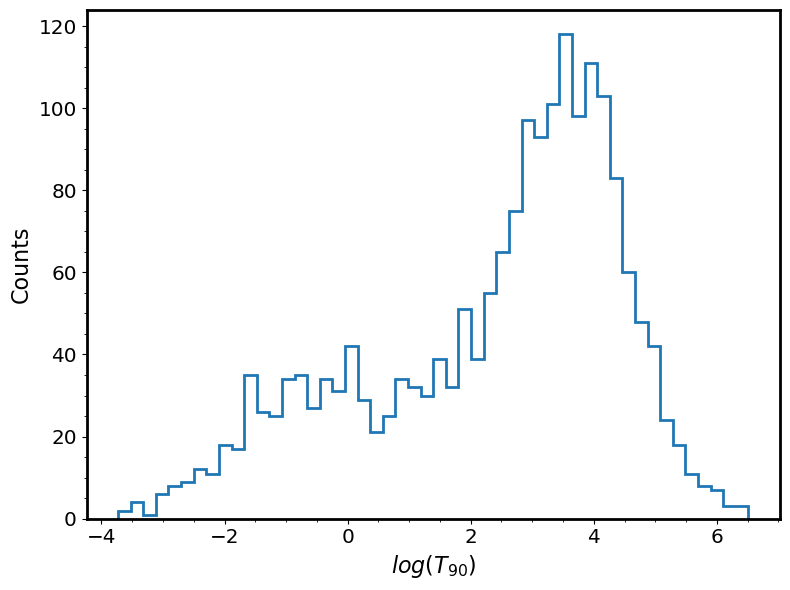

In [5]:
plt.hist(logT90, bins=50, histtype='step')#, color='k')
plt.xlabel('$log(T_{90})$')
plt.ylabel('Counts')
plt.show()

## MCMC

In [43]:
from mcmc import *
from mcmc_plots import (plot_trace_mcmc, plot_marginal_distributions, 
                       plot_autocorrelations, plot_distribution)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
LOAD = False

rng = np.random.default_rng(1234)
x = np.linspace(0.,1.,100)

logT90       = arr[:,0]
sigma_logT90 = arr[:,1]
#nbins        = 256

theta_true = {"w": 0.3, "mu1": -0.5, "mu2": 3.5, "sigma1": 0.8, "sigma2": 1.0}
logT90 = generate_data(theta_true, N = len(logT90), rng=rng, sigma_logT90=sigma_logT90)

theta_sim = np.array((theta_true['w'], 
                    theta_true['mu1'], 
                    theta_true['mu2']-theta_true['mu1'], 
                    theta_true['sigma1'],
                    theta_true['sigma2'])) 

print('logL (simulation)= ', log_likelihood(logT90, theta_sim, sigma_logT90))

# define the prior bounds
bounds = [[0,1],[-3,2], [0, 6], [0,4], [0,4]]

# run the mh sampler

n_steps  = 50000

if LOAD == 0:
    theta0 = np.array((rng.uniform(bounds[0][0],bounds[0][1]),
                       rng.uniform(bounds[1][0],bounds[1][1]),
                       rng.uniform(bounds[2][0],bounds[2][1]),
                       rng.uniform(bounds[3][0],bounds[3][1]),
                       rng.uniform(bounds[4][0],bounds[4][1])))
    samples = metropolis_hastings(theta0, logT90, bounds, rng = rng, 
                                  sigma_logT90 = 0.0, n = n_steps)
    np.savetxt('chain.txt',samples)
else:
    samples = np.loadtxt('chain.txt')

logL (simulation)=  -3730.0687128964673
iteration 0: acceptance 0.0
iteration 1: acceptance 0.0
iteration 2: acceptance 0.0
iteration 3: acceptance 0.0
iteration 4: acceptance 0.16666666666666666
iteration 5: acceptance 0.14285714285714285
iteration 6: acceptance 0.25
iteration 7: acceptance 0.3333333333333333
iteration 8: acceptance 0.4
iteration 9: acceptance 0.45454545454545453
iteration 10: acceptance 0.4166666666666667
iteration 11: acceptance 0.46153846153846156
iteration 12: acceptance 0.42857142857142855
iteration 13: acceptance 0.4
iteration 14: acceptance 0.4375
iteration 15: acceptance 0.4117647058823529
iteration 16: acceptance 0.3888888888888889
iteration 17: acceptance 0.42105263157894735
iteration 18: acceptance 0.4
iteration 19: acceptance 0.38095238095238093
iteration 20: acceptance 0.4090909090909091
iteration 21: acceptance 0.43478260869565216
iteration 22: acceptance 0.4166666666666667
iteration 23: acceptance 0.4
iteration 24: acceptance 0.38461538461538464
iterati

Saved: figure/trace_plot_mcmc.png (PNG 300 dpi) and figure/trace_plot_mcmc.pdf (PDF)


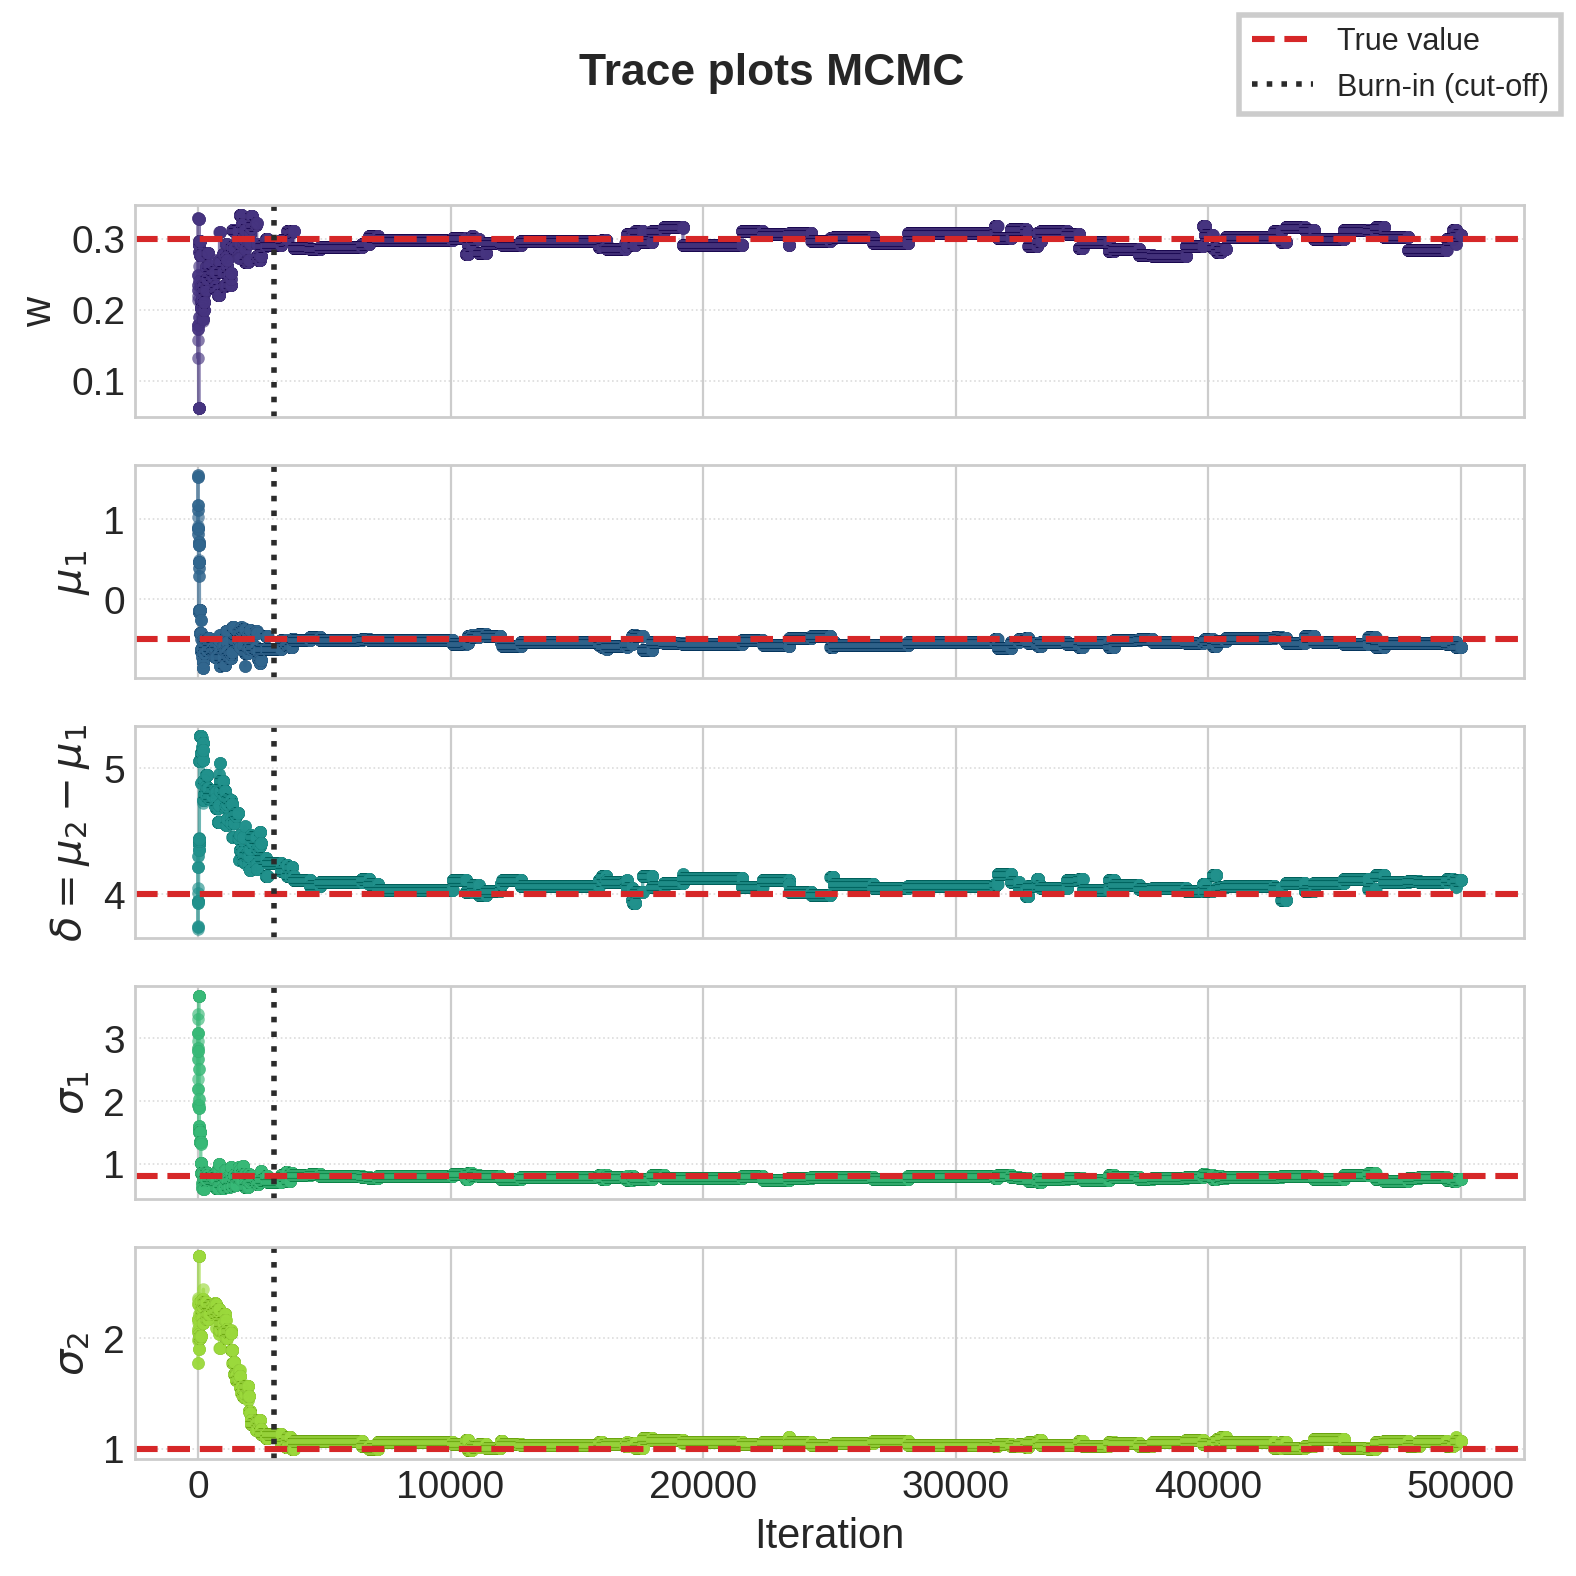

In [45]:
fig, axes = plot_trace_mcmc(samples, 'trace_plot_mcmc', theta_sim, burnin=3000)

In [86]:
# burnin = 1000 #per valori reali
burnin = 3000

samples_new = samples[burnin:,:]

/home/leo/Desktop/Bayesian_probability/mcmc_plots.py:272: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ncol=3,
/home/leo/Desktop/Bayesian_probability/mcmc_plots.py:273: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  frameon=True,


Saved: figure/marginal_distribution_mcmc.png (PNG 300 dpi) and figure/marginal_distribution_mcmc.pdf (PDF)


/home/leo/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


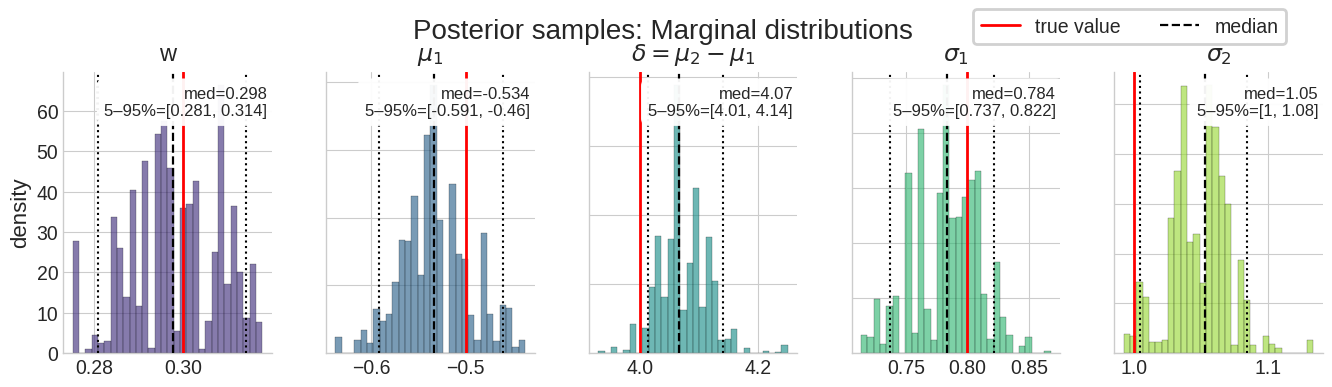

In [47]:
fig2, axes2 = plot_marginal_distributions(samples_new, 'marginal_distribution_mcmc', theta_sim)

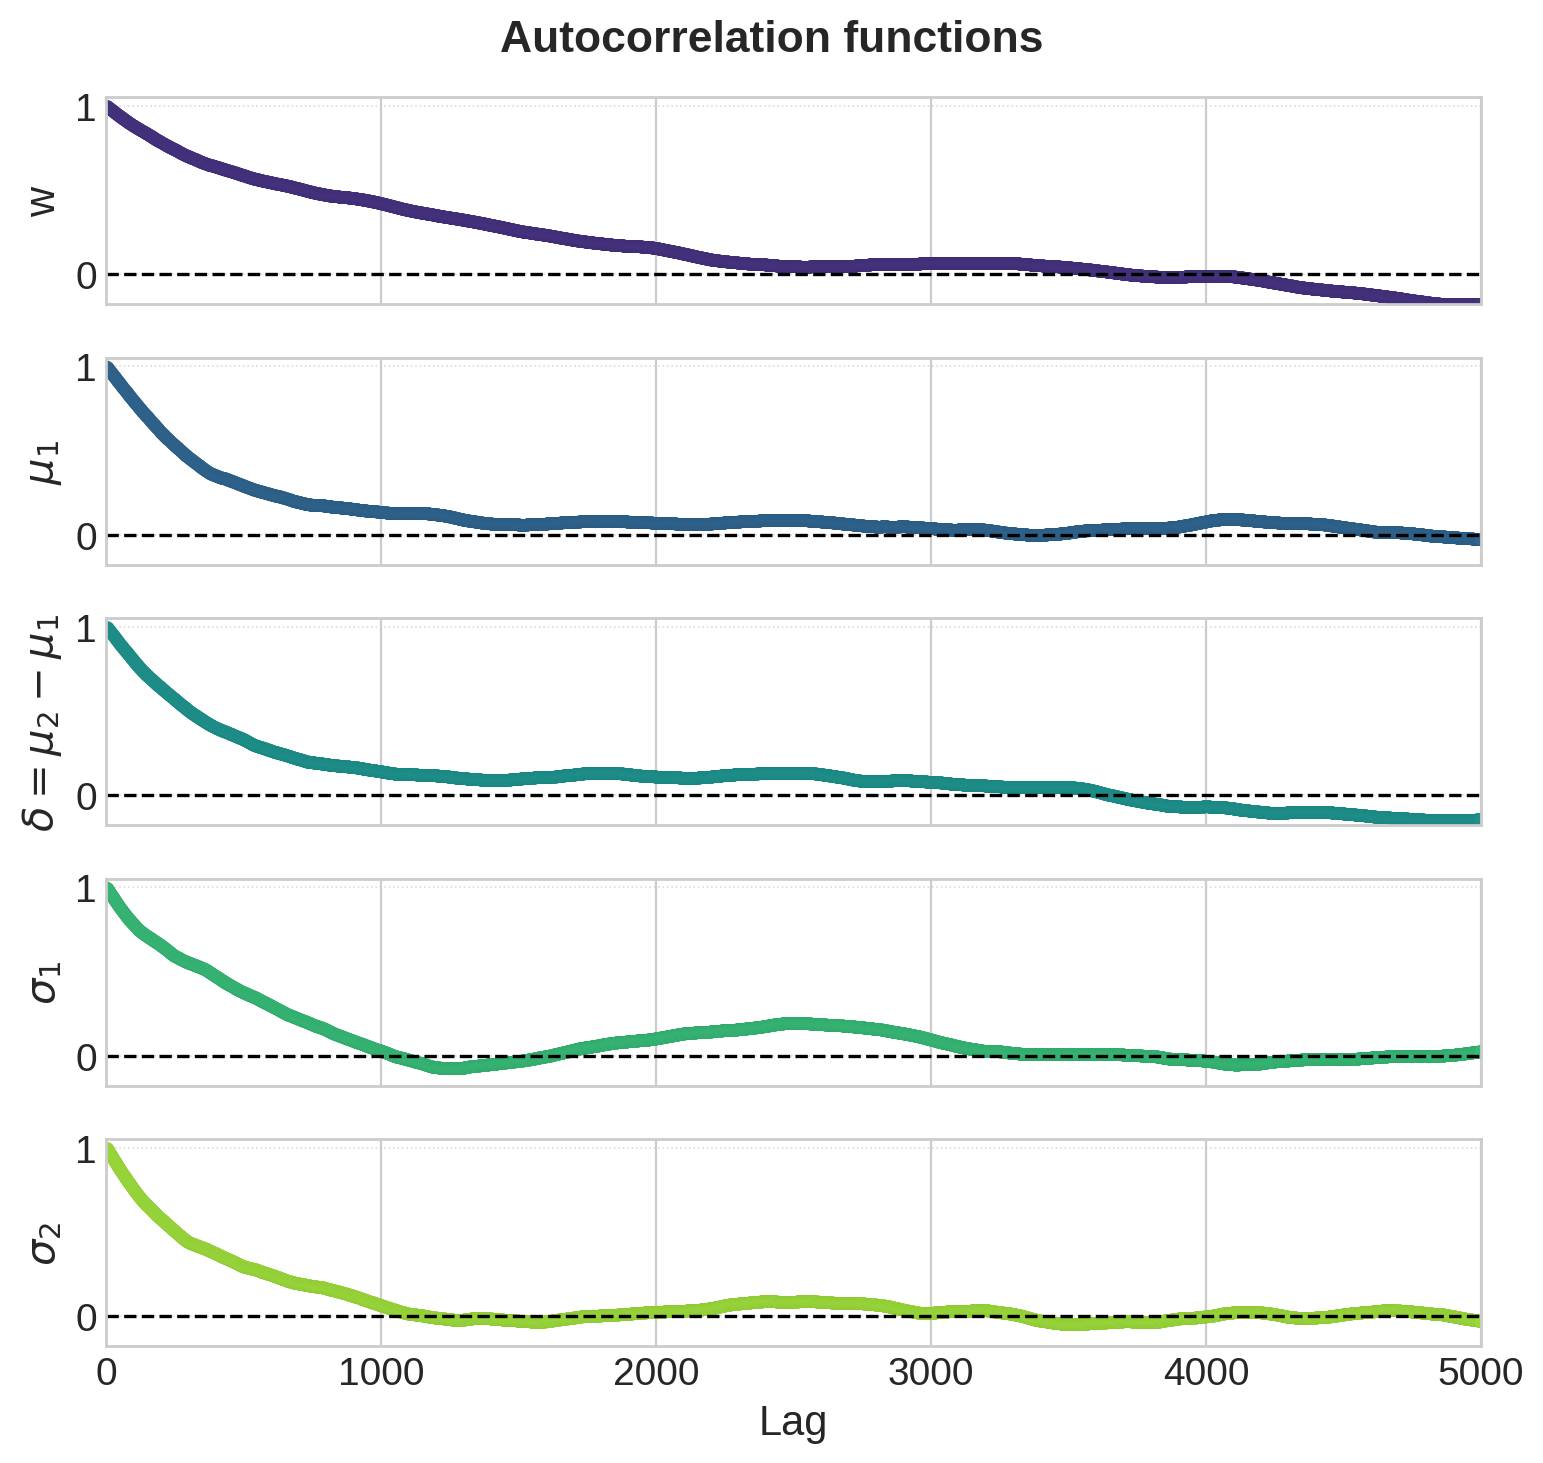

In [48]:
fig3, axes3 = plot_autocorrelations(samples_new, 'autocorrelation_mcmc', max_lag=5000)

In [52]:
def autocorr(x, lag):
    return np.corrcoef(np.array([x[:-lag], x[lag:]]))[0,1]

def ess(x):
    n = len(x)
    # calcolo autocorrelazione fino a quando diventa negativa
    rho = []
    for k in range(1, n//2):
        r = autocorr(x, k)
        if r <= 0: 
            break
        rho.append(r)
    tau = 1 + 2*np.sum(rho)
    return n / tau

In [87]:
for i, key in enumerate(theta_true.keys()):
    print(f'N_ESS ({key}) = {ess(samples_new[:,i]):.0f}')

N_ESS (w) = 23
N_ESS (mu1) = 42
N_ESS (mu2) = 33
N_ESS (sigma1) = 56
N_ESS (sigma2) = 61


In [128]:
print('covarianza =\n', np.cov(samples_new, rowvar=False))

covarianza =
 [[ 1.04362179e-04  2.01940298e-05 -2.73474257e-05  3.27109181e-05
  -7.78837317e-05]
 [ 2.01940298e-05  1.54529434e-03 -1.36954138e-03  3.81879025e-04
  -3.85525363e-04]
 [-2.73474257e-05 -1.36954138e-03  2.65712446e-03 -3.12403797e-04
   6.62352751e-04]
 [ 3.27109181e-05  3.81879025e-04 -3.12403797e-04  7.63175033e-04
  -2.63993039e-04]
 [-7.78837317e-05 -3.85525363e-04  6.62352751e-04 -2.63993039e-04
   7.44746707e-04]]


In [49]:
thinning = 1000
samples_new = samples_new[::thinning,:]

In [33]:
print('covarianza =\n', np.cov(samples_new, rowvar=False))

covarianza =
 [[ 9.25498431e-05  3.62873962e-05 -7.20073360e-05  4.37712518e-05
  -5.55277102e-05]
 [ 3.62873962e-05  1.32238803e-03 -1.21089150e-03  4.26501231e-04
  -2.45685649e-04]
 [-7.20073360e-05 -1.21089150e-03  2.21703661e-03 -3.59810199e-04
   3.48767180e-04]
 [ 4.37712518e-05  4.26501231e-04 -3.59810199e-04  7.93140916e-04
  -1.81614835e-04]
 [-5.55277102e-05 -2.45685649e-04  3.48767180e-04 -1.81614835e-04
   5.08601934e-04]]


In [50]:
samples_new.shape

(47, 5)

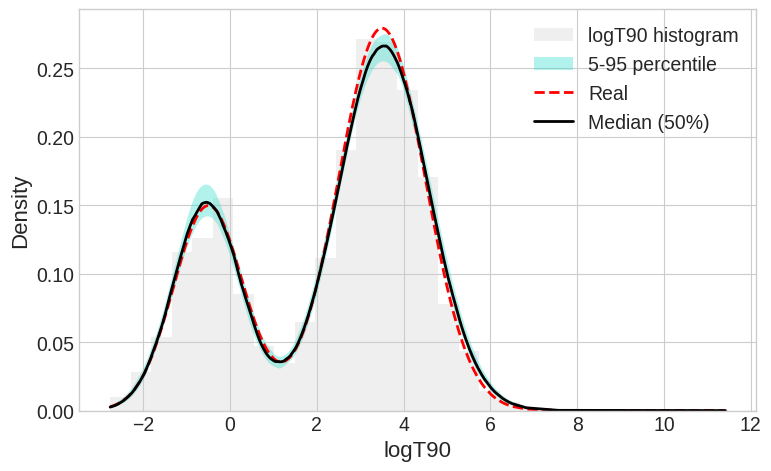

In [51]:
fig4, axes4 = plot_distribution(logT90, samples_new, 'distribution_mcmc', theta_true=theta_sim)

## MC adaptive

In [114]:
def adaptive_metropolis_hastings(theta0, x, bounds,
                                 rng = None,
                                 sigma_logT90 = 0.0,
                                 n = 10000,
                                 adapt_interval = 100,
                                 target_accept = 0.234,
                                 epsilon = 1e-6,
                                 initial_cov = None,
                                 verbose = True):
    """
    Adaptive Metropolis-Hastings:
    - theta0: starting vector (numpy array)
    - x, bounds, sigma_logT90: come prima
    - n: numero di iterazioni
    - adapt_interval: ogni quante iterazioni aggiornare cov & scale
    - target_accept: tasso di accettazione desiderato (es. 0.234)
    - epsilon: jitter per stabilizzare la covarianza
    - initial_cov: matrice di covarianza di partenza (dxd). Se None uso diag(1e-2)
    - restituisce: samples (n x d), acc_rate_overall, dict con info diagnostiche
    """
    if rng is None:
        rng = np.random

    theta0 = np.atleast_1d(theta0).astype(np.float64)
    d = theta0.shape[0]

    # parametri base per la scalatura consigliata (Roberts et al.)
    base_scale = (2.38**2) / float(d)

    # inizializza covarianza iniziale
    if initial_cov is None:
        initial_cov = np.eye(d) * 1e-2

    # stato MCMC
    theta_curr = theta0.copy()
    logP_curr = log_posterior(x, theta_curr, bounds, sigma_logT90 = sigma_logT90)

    samples = np.zeros((n, d), dtype=np.float64)
    accepted = 0

    # stima online media e S (Welford)
    mean = theta_curr.copy()
    S = np.zeros((d, d), dtype=np.float64)
    sample_count = 1  # abbiamo già il punto iniziale come "primo"
    # inizializziamo con il primo punto
    samples[0,:] = theta_curr

    # cov_est: matrice usata per le proposte (inizialmente initial_cov)
    cov_est = initial_cov.copy()

    # log-scale (adattamento del fattore di scala): inizialmente 0 (scala = 1)
    log_scale = 0.0

    # memoria per accettazioni recenti
    recent_accepts = []

    # diagnostica
    cov_history = []
    scale_history = []
    accept_history = []

    for i in range(1, n):
        # costruisci covariaza proposta
        prop_cov = base_scale * np.exp(log_scale) * (cov_est + epsilon * np.eye(d))
        # draw proposal
        theta_prop = rng.multivariate_normal(theta_curr, prop_cov)
        logP_prop = log_posterior(x, theta_prop, bounds, sigma_logT90 = sigma_logT90)

        # MH accettazione
        if np.isfinite(logP_prop) and (logP_prop - logP_curr > np.log(rng.uniform())):
            theta_curr = theta_prop
            logP_curr = logP_prop
            accepted += 1
            acc = 1
        else:
            acc = 0

        # registra sample
        samples[i,:] = theta_curr

        # aggiorna stima online della media e S con il nuovo sample theta_curr
        sample_count += 1
        delta = theta_curr - mean
        mean = mean + delta / sample_count
        delta2 = theta_curr - mean
        S = S + np.outer(delta, delta2)  # accumula (sample_count-1)*cov

        # registra accettazione recente
        recent_accepts.append(acc)
        if len(recent_accepts) > adapt_interval:
            # mantieni solo l'ultima finestra
            recent_accepts.pop(0)

        # ogni adapt_interval aggiorna cov_est e log_scale (diminishing adaptation)
        if (i % adapt_interval) == 0:
            # stima covarianca empirica (se sample_count > 2)
            if sample_count > 2:
                cov_emp = S / (sample_count - 1)
                # assicurati che non contenga NaN o inf
                if np.any(~np.isfinite(cov_emp)):
                    cov_emp = cov_est.copy()
            else:
                cov_emp = cov_est.copy()

            cov_est = cov_emp.copy()

            # calcola tasso di accettazione nella finestra
            window_accept_rate = np.mean(recent_accepts) if len(recent_accepts) > 0 else 0.0

            # passo di adattamento che diminuisce con i (diminishing)
            # gamma = i^{-alpha} con alpha in (0.5,1), uso alpha = 0.6
            gamma = (i+1) ** (-0.6)

            # aggiorna log-scale in base alla differenza tra accept e target
            log_scale += gamma * (window_accept_rate - target_accept)

            # registra storici per debug
            cov_history.append(cov_est.copy())
            scale_history.append(np.exp(log_scale))
            accept_history.append(window_accept_rate)

            if verbose:
                overall_accept = accepted / float(i+1)
                print(f"iter {i:6d} / {n:6d} | window_acc = {window_accept_rate:.3f} | overall_acc = {overall_accept:.3f} | scale = {np.exp(log_scale):.4f}")

    overall_rate = accepted / float(n)
    if verbose:
        print(f"Adaptive Metropolis finished. Overall acceptance rate = {overall_rate:.4f}")

    info = {
        "overall_accept_rate": overall_rate,
        "cov_history": cov_history,
        "scale_history": scale_history,
        "accept_history": accept_history,
        "final_cov_est": cov_est,
        "final_scale": np.exp(log_scale),
        "mean_estimate": mean
    }

    return samples, info

In [122]:
LOAD = False

rng = np.random.default_rng(1234)
x = np.linspace(0.,1.,100)

logT90       = arr[:,0]
sigma_logT90 = arr[:,1]
#nbins        = 256

theta_true = {"w": 0.3, "mu1": -0.5, "mu2": 3.5, "sigma1": 0.8, "sigma2": 1.0}
logT90 = generate_data(theta_true, N = len(logT90), rng=rng, sigma_logT90=sigma_logT90)

theta_sim = np.array((theta_true['w'], 
                    theta_true['mu1'], 
                    theta_true['mu2']-theta_true['mu1'], 
                    theta_true['sigma1'],
                    theta_true['sigma2'])) 

print('logL (simulation)= ', log_likelihood(logT90, theta_sim, sigma_logT90))

# define the prior bounds
bounds = [[0,1],[-3,2], [0, 6], [0,4], [0,4]]

# run the mh sampler

n_steps  = 50000
initial_cov = np.array(([ 0.01545509,  0.08896731, -0.02650015, -0.12120278, -0.05484408],
                           [ 0.08896731,  0.55401367, -0.19294877, -0.70861588, -0.31702254],
                           [-0.02650015, -0.19294877,  0.08722617,  0.21468223,  0.09385355],
                           [-0.12120278, -0.70861588,  0.21468223,  0.99010538,  0.43217997],
                           [-0.05484408, -0.31702254,  0.09385355,  0.43217997,  0.19659419])) 

if LOAD == 0:
    theta0 = np.array((rng.uniform(bounds[0][0],bounds[0][1]),
                       rng.uniform(bounds[1][0],bounds[1][1]),
                       rng.uniform(bounds[2][0],bounds[2][1]),
                       rng.uniform(bounds[3][0],bounds[3][1]),
                       rng.uniform(bounds[4][0],bounds[4][1])))
    samples, diagnostics = adaptive_metropolis_hastings(theta0, logT90, bounds, rng = rng, 
                                                        sigma_logT90 = 0.0, n = n_steps,
                                                        initial_cov=None, verbose=True)
    np.savetxt('chain_adaptive.txt',samples)
else:
    samples = np.loadtxt('chain_adaptive.txt')

logL (simulation)=  -3730.0687128964673
iter    100 /  50000 | window_acc = 0.260 | overall_acc = 0.257 | scale = 1.0016
iter    200 /  50000 | window_acc = 0.070 | overall_acc = 0.164 | scale = 0.9948
iter    300 /  50000 | window_acc = 0.040 | overall_acc = 0.123 | scale = 0.9886
iter    400 /  50000 | window_acc = 0.040 | overall_acc = 0.102 | scale = 0.9833
iter    500 /  50000 | window_acc = 0.020 | overall_acc = 0.086 | scale = 0.9783
iter    600 /  50000 | window_acc = 0.030 | overall_acc = 0.077 | scale = 0.9740
iter    700 /  50000 | window_acc = 0.010 | overall_acc = 0.067 | scale = 0.9697
iter    800 /  50000 | window_acc = 0.000 | overall_acc = 0.059 | scale = 0.9656
iter    900 /  50000 | window_acc = 0.000 | overall_acc = 0.052 | scale = 0.9618
iter   1000 /  50000 | window_acc = 0.010 | overall_acc = 0.048 | scale = 0.9584
iter   1100 /  50000 | window_acc = 0.000 | overall_acc = 0.044 | scale = 0.9551
iter   1200 /  50000 | window_acc = 0.000 | overall_acc = 0.040 | sca

Saved: figure/trace_plot_mcmc_adaptive.png (PNG 300 dpi) and figure/trace_plot_mcmc_adaptive.pdf (PDF)


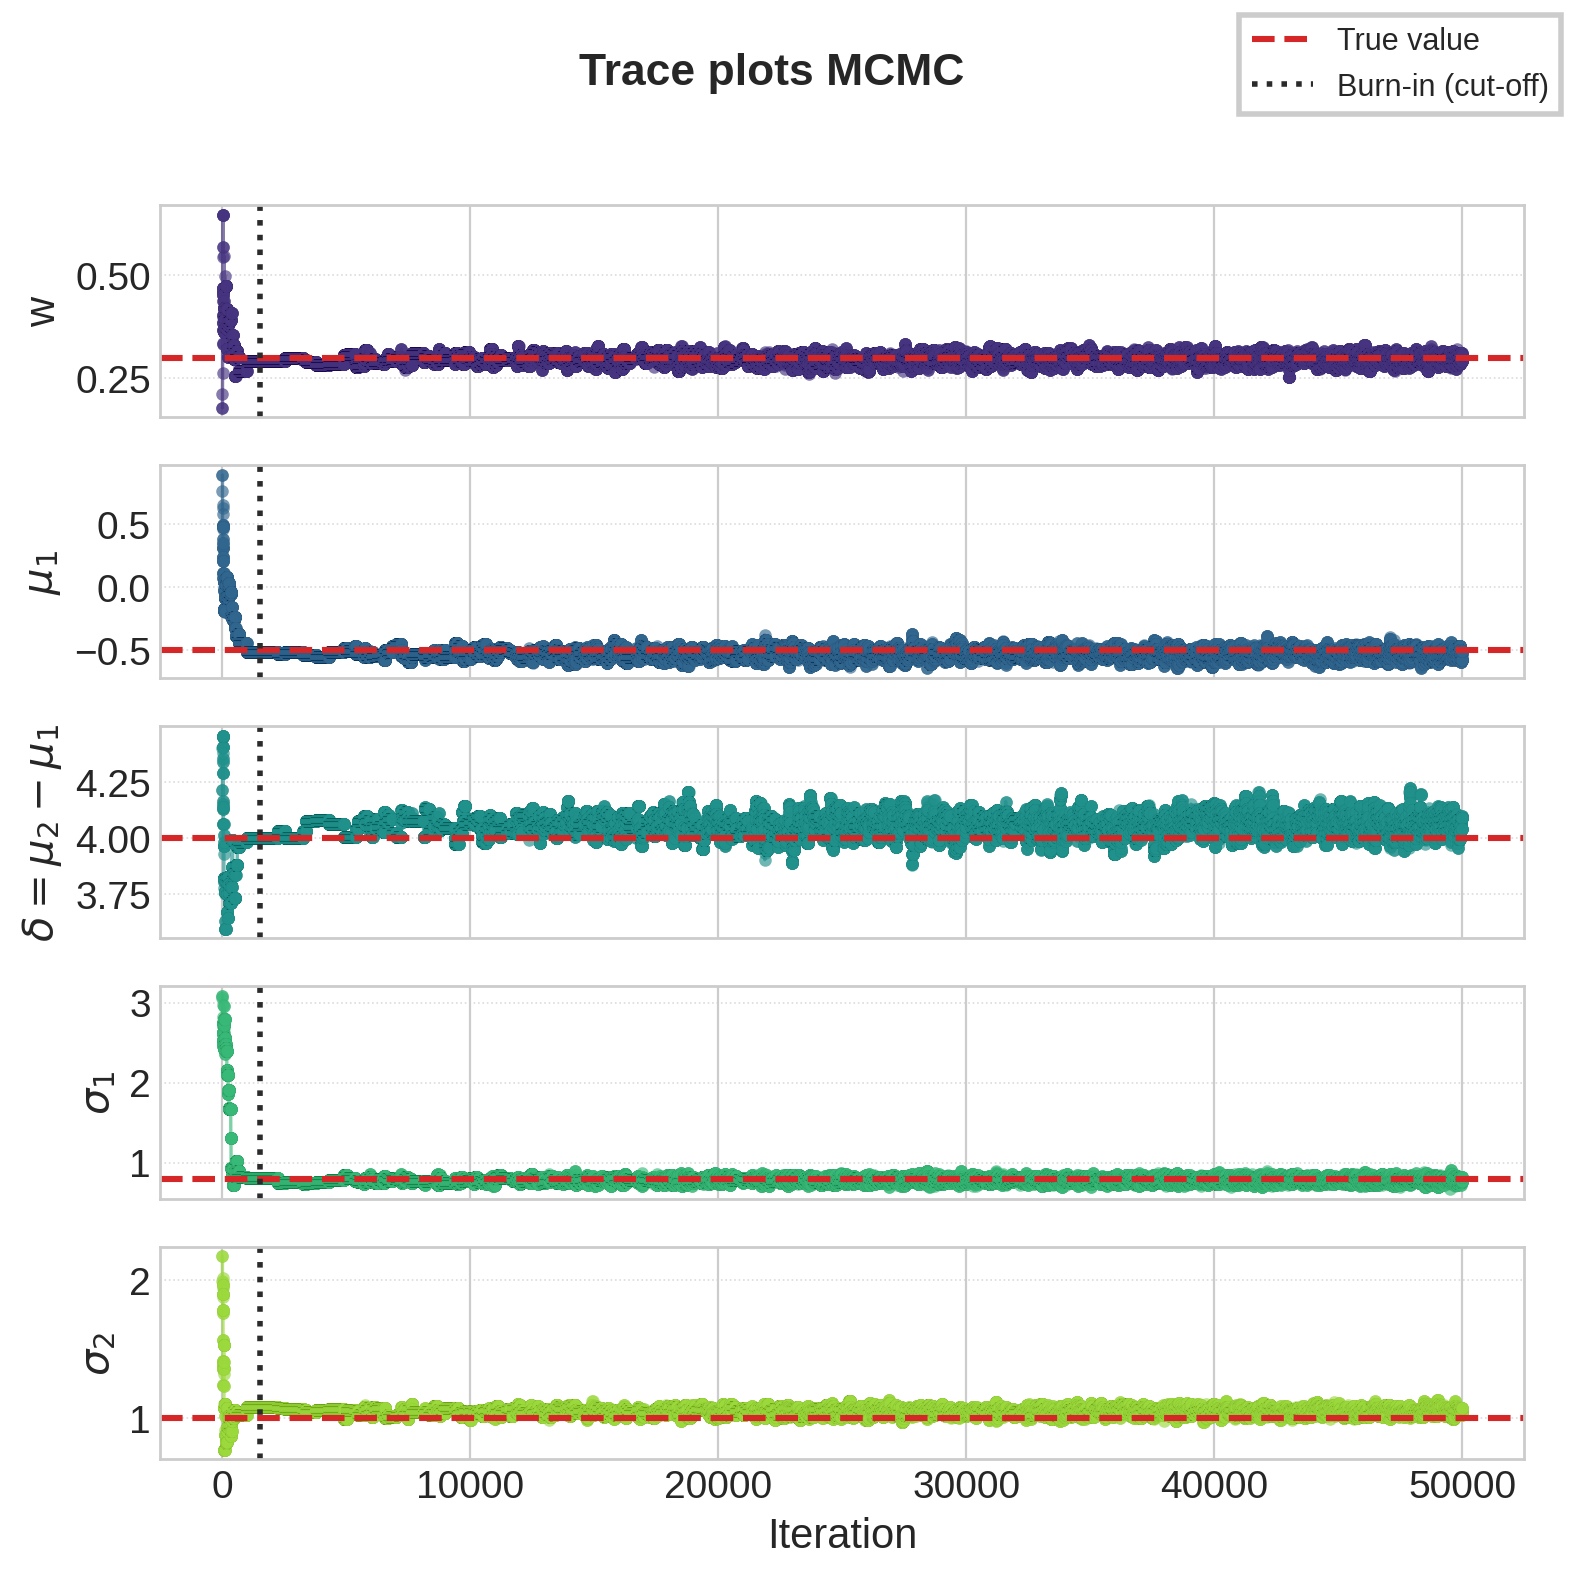

In [123]:
fig, axes = plot_trace_mcmc(samples, 'trace_plot_mcmc_adaptive', theta_sim, burnin=1500)

In [124]:
burnin = 1500

samples_new = samples[burnin:]

/home/leo/Desktop/Bayesian_probability/mcmc_plots.py:272: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ncol=3,
/home/leo/Desktop/Bayesian_probability/mcmc_plots.py:273: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  frameon=True,


Saved: figure/marginal_distribution_mcmc_adaptive.png (PNG 300 dpi) and figure/marginal_distribution_mcmc_adaptive.pdf (PDF)


/home/leo/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


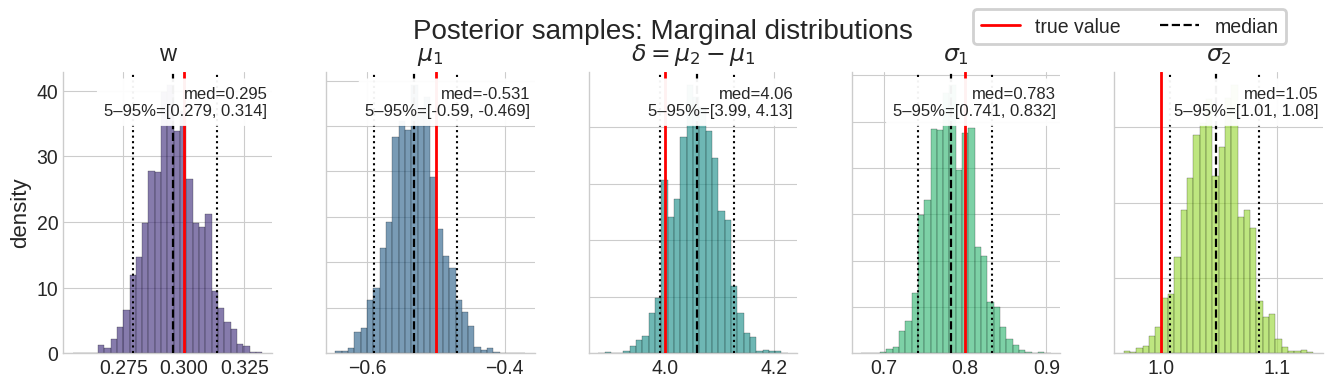

In [125]:
fig2, axes2 = plot_marginal_distributions(samples_new, 'marginal_distribution_mcmc_adaptive', theta_sim)

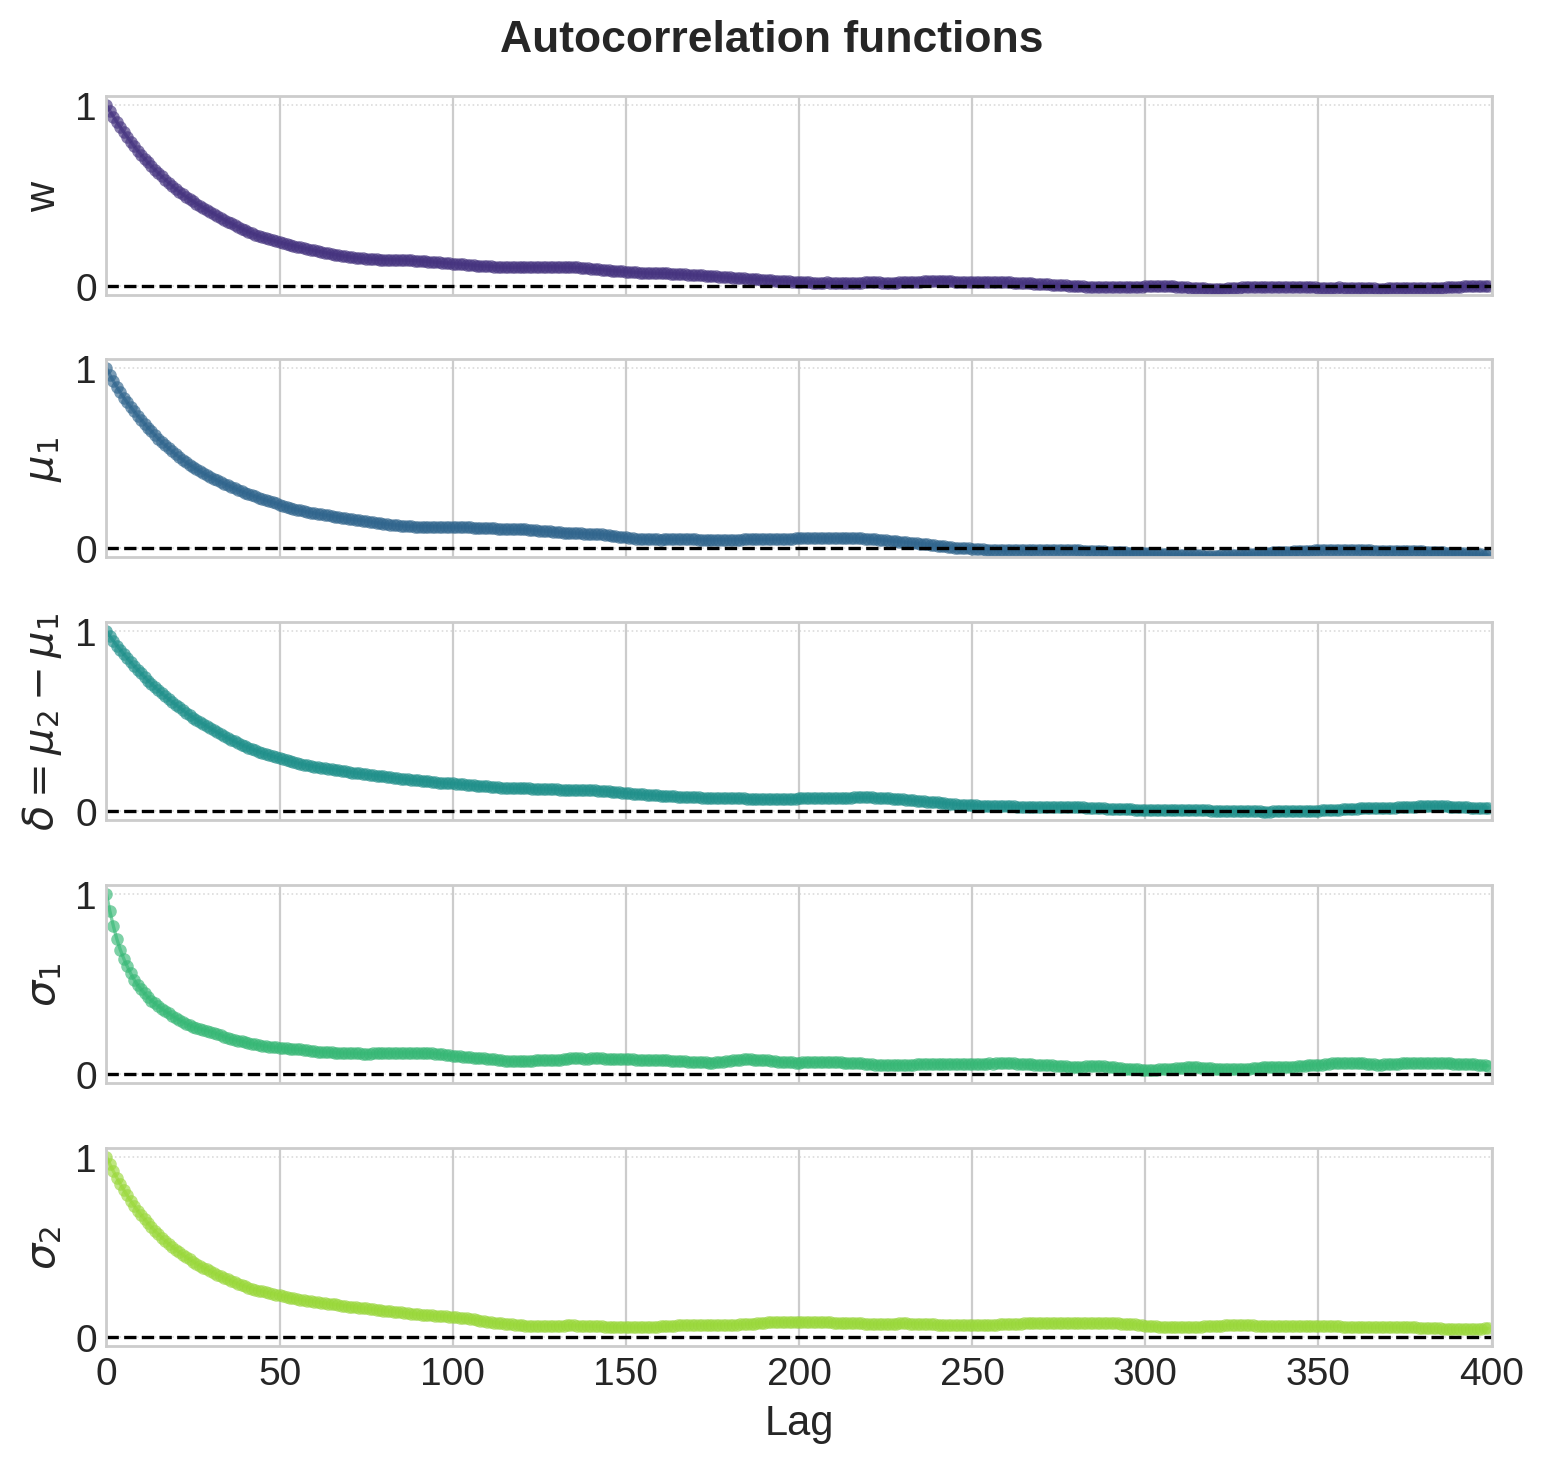

In [129]:
fig3, axes3 = plot_autocorrelations(samples_new, 'autocorrelation_mcmc_adaptive', max_lag=400)

In [130]:
for i, key in enumerate(theta_true.keys()):
    print(f'N_ESS ({key}) = {ess(samples_new[:,i]):.0f}')

N_ESS (w) = 567
N_ESS (mu1) = 568
N_ESS (mu2) = 454
N_ESS (sigma1) = 487
N_ESS (sigma2) = 412


In [131]:
thinning = 100
samples_new = samples_new[::thinning,:]
samples_new.shape

(485, 5)

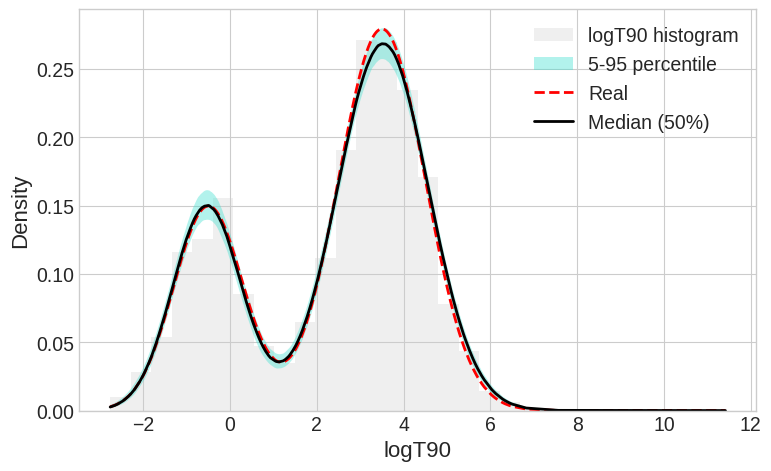

In [132]:
fig4, axes4 = plot_distribution(logT90, samples_new, 'distribution_mcmc_adaptive', theta_true=theta_sim)